<a href="https://colab.research.google.com/github/puffyq/python-dl/blob/main/chap8_dog_and_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jingyuequan","key":"c8534ed98c4e78f4eb8c47ce65c332d9"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:49<00:00, 19.1MB/s]
100% 812M/812M [00:49<00:00, 17.3MB/s]


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip

In [6]:
import os, shutil, pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir /subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      shutil.copyfile(src=original_dir/fname, dst=dir/fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)x
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [15]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validatoin_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size = 32
)
test_dataset= image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convert_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validatoin_dataset,
    callbacks=callbacks
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.5002 - loss: 0.7271 - val_accuracy: 0.6220 - val_loss: 0.6906
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.5443 - loss: 0.6930 - val_accuracy: 0.5000 - val_loss: 0.6865
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.5700 - loss: 0.6814 - val_accuracy: 0.5480 - val_loss: 0.7387
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.6104 - loss: 0.6873 - val_accuracy: 0.6500 - val_loss: 0.6104
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.6408 - loss: 0.6341 - val_accuracy: 0.5830 - val_loss: 0.6623
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.6645 - loss: 0.6013 - val_accuracy: 0.7060 - val_loss: 0.5754
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.7151 - loss: 0.5561 - val_accuracy: 0.6930 - val_loss: 0.6159
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7438 - loss: 0.5300 - val_accuracy: 0.673

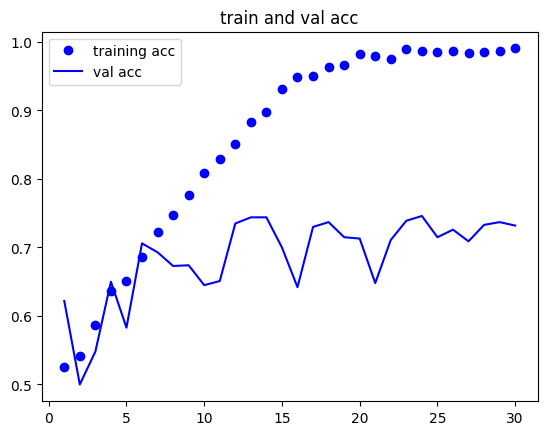

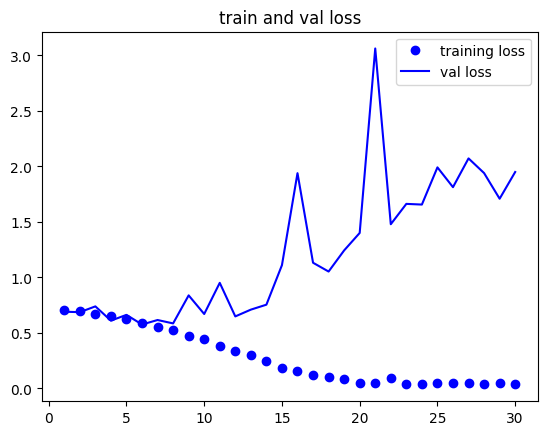

In [13]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="training acc")
plt.plot(epochs, val_accuracy, "b", label="val acc")
plt.title("train and val acc")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="val loss")
plt.title("train and val loss")
plt.legend()
plt.show()

In [17]:
test_model = keras.models.load_model("convert_from_scratch.keras")
test_model, test_acc = test_model.evaluate(test_dataset)
print(f"test acc: {test_acc: .3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6888 - loss: 0.5932
test acc:  0.695


In [18]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

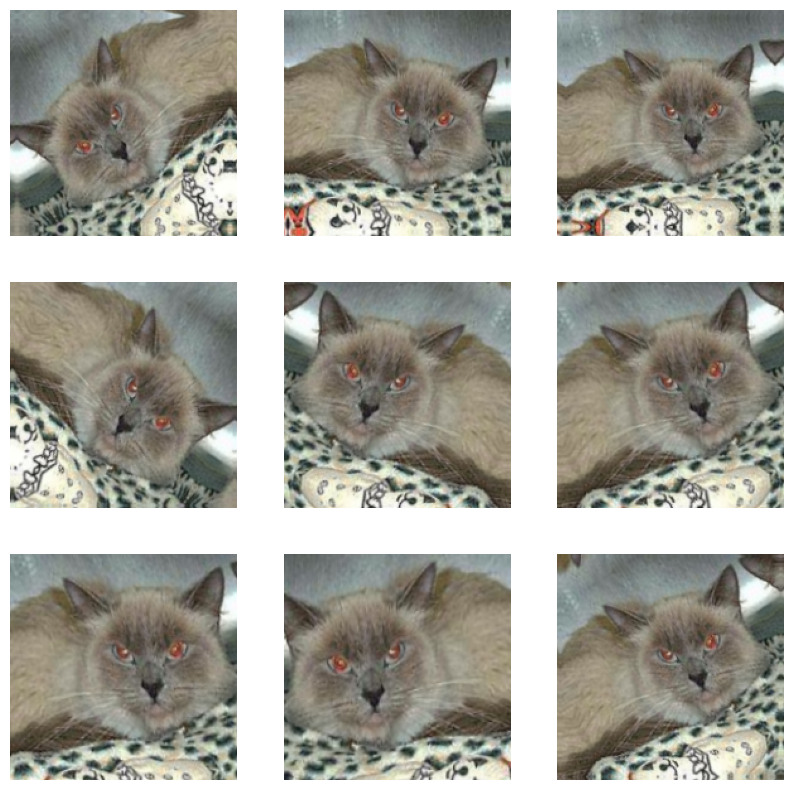

In [19]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convert_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validatoin_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.5244 - loss: 0.7084 - val_accuracy: 0.5000 - val_loss: 0.6924
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.5079 - loss: 0.6947 - val_accuracy: 0.5050 - val_loss: 0.6994
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5604 - loss: 0.6874 - val_accuracy: 0.6080 - val_loss: 0.6737
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5862 - loss: 0.6759 - val_accuracy: 0.5350 - val_loss: 0.6870
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.5913 - loss: 0.6613 - val_accuracy: 0.5790 - val_loss: 0.6643
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.6488 - loss: 0.6435 - val_accuracy: 0.6330 - val_loss: 0.6378
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.6565 - loss: 0.6381 - val_accuracy: 0.5700 - val_loss: 0.7103
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.6541 - loss: 0.6271 - val_accuracy: 0.

# test part

In [23]:
test_model = keras.models.load_model("convert_from_scratch_with_augmentation.keras")
test_model, test_acc = test_model.evaluate(test_dataset)
print(f"test acc: {test_acc: .3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8405 - loss: 0.4621
test acc:  0.845


In [25]:
conv_base= keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top=False,
    input_shape=(180,180,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [26]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# purely features extraction

import numpy as np

def get_features_and_labels(dataset):
  all_features=[]
  all_labels=[]
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_feature, train_labels = get_features_and_labels(train_dataset)
val_feature, val_labels = get_features_and_labels(validatoin_dataset)
test_feature, test_labels = get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [30]:
train_feature.shape

(2000, 5, 5, 512)

In [34]:
inputs = keras.Input(shape=(5,5,512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, output)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"]
              )

callbacks=[
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_feature, train_labels,
    epochs=20,
    validation_data=(val_feature, val_labels),
    callbacks=callbacks
)



Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8777 - loss: 25.6265 - val_accuracy: 0.9310 - val_loss: 13.6784
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9712 - loss: 3.7989 - val_accuracy: 0.9530 - val_loss: 10.3853
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9867 - loss: 1.5631 - val_accuracy: 0.9670 - val_loss: 5.1826
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9951 - loss: 0.7816 - val_accuracy: 0.9740 - val_loss: 4.1396
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9888 - loss: 0.7928 - val_accuracy: 0.9420 - val_loss: 15.6997
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9930 - loss: 1.3393 - val_accuracy: 0.9720 - val_loss: 5.1473
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9941 - loss: 0.5446 - val_accuracy: 0.9770 - val_loss: 5.1629
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9969 - loss: 0.3889 - val_accuracy: 0.9710 - val_

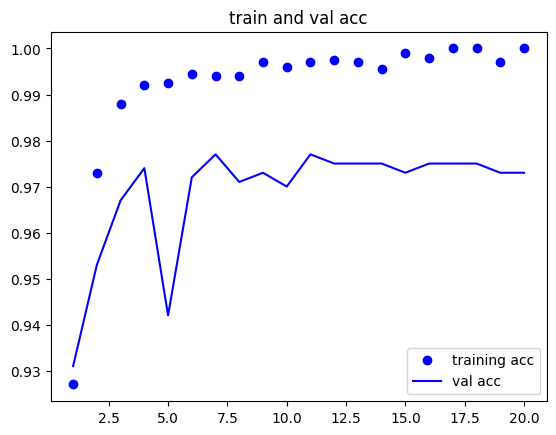

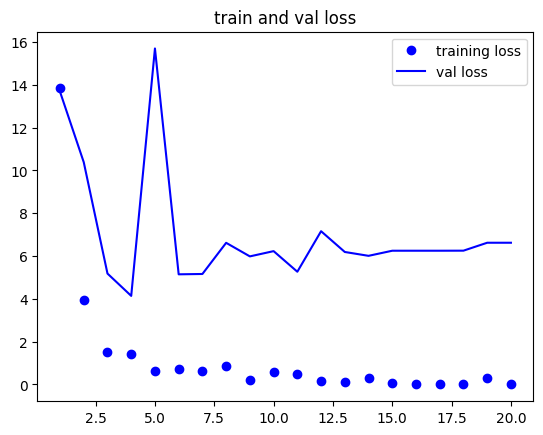

In [35]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="training acc")
plt.plot(epochs, val_accuracy, "b", label="val acc")
plt.title("train and val acc")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="training loss")
plt.plot(epochs, val_loss, "b", label="val loss")
plt.title("train and val loss")
plt.legend()
plt.show()

In [36]:
conv_base= keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top=False)
conv_base.trainable=False


In [39]:
inputs = keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, output)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"]
              )

callbacks=[
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validatoin_dataset,
    callbacks=callbacks
)



Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 219ms/step - accuracy: 0.8350 - loss: 39.2440 - val_accuracy: 0.9680 - val_loss: 3.9647
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.9513 - loss: 7.6568 - val_accuracy: 0.9700 - val_loss: 2.8132
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.9680 - loss: 4.0389 - val_accuracy: 0.9750 - val_loss: 3.5308
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.9590 - loss: 4.2047 - val_accuracy: 0.9590 - val_loss: 7.7993
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.9585 - loss: 4.1725 - val_accuracy: 0.9680 - val_loss: 4.1440
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - accuracy: 0.9672 - loss: 3.4646 - val_accuracy: 0.9740 - val_loss: 2.7108
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.9812 - loss: 1.5764 - val_accuracy: 0.9590 - val_loss: 7.8509
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - accuracy: 0.9682 - loss: 3.2103 - val_acc

In [40]:
test_model = keras.models.load_model("feature_extraction_with_augmentation.keras")
test_model, test_acc = test_model.evaluate(test_dataset)
print(f"test acc: {test_acc: .3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.9757 - loss: 1.7896
test acc:  0.976


In [41]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [42]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"]
              )

callbacks=[
    keras.callbacks.ModelCheckpoint(
        filepath="fineturn.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validatoin_dataset,
    callbacks=callbacks
)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 224ms/step - accuracy: 0.9900 - loss: 0.2402 - val_accuracy: 0.9830 - val_loss: 1.3143
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.9934 - loss: 0.1463 - val_accuracy: 0.9780 - val_loss: 1.0745
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.9929 - loss: 0.2928 - val_accuracy: 0.9810 - val_loss: 1.2793
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.9931 - loss: 0.3089 - val_accuracy: 0.9820 - val_loss: 1.2639
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.9956 - loss: 0.1635 - val_accuracy: 0.9800 - val_loss: 1.1280
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.9910 - loss: 0.3575 - val_accuracy: 0.9780 - val_loss: 1.6743
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.9911 - loss: 0.1912 - val_accuracy: 0.9760 - val_loss: 1.6430
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.9926 - loss: 0.2149 - val_accu

In [43]:
test_model = keras.models.load_model("fineturn.keras")
test_model, test_acc = test_model.evaluate(test_dataset)
print(f"test acc: {test_acc: .3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.9761 - loss: 2.0916
test acc:  0.979
